## Pytorch code percolation model with Ohtsuki CNN

## initializations

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
seed=42
import torch
torch.manual_seed(seed)
import numpy as np
np.random.seed(seed+1)

In [3]:
from __future__ import print_function, division
import os
print('torch version:',torch.__version__)
import sklearn
print('sklearn version:', sklearn.__version__)

torch version: 1.3.1
sklearn version: 0.22.1


In [6]:
import torchvision
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np
import time
import os
import copy

In [7]:
t=torch.Tensor()
print(t.dtype)
print(t.device)
print(t.layout)

torch.float32
cpu
torch.strided


Now we switch to the GPU

In [8]:
device=t.device

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
print(device)


cuda:0


## starting the main code

In [8]:
class DatasetFolder2(torchvision.datasets.DatasetFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(DatasetFolder2, self).__getitem__(index)
        # the image file path
        path = self.samples[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [11]:
training_set=0
validation_set=0
validation_split=0.1
dataname='L100-new'
path='../../../'+dataname
#transform=torchvision.transforms.ToTensor()



In [12]:
def pickle_loader(input):
    import pickle
    return pickle.load(open(input, 'rb'))

whole_dataset= DatasetFolder2(root=path, loader=pickle_loader, extensions='.pkl')


In [13]:
data_size = len(whole_dataset)

split=int(np.floor(validation_split*data_size))
training=int(data_size-split)
# split the data into training and validation
training_set, validation_set= torch.utils.data.random_split(whole_dataset,(training,split))

In [14]:
batch_size=256
train = torch.utils.data.DataLoader(
        dataset=training_set,
        batch_size=batch_size,
        shuffle=True)

val = torch.utils.data.DataLoader(
        dataset=validation_set,
        batch_size=batch_size,
        shuffle=True)


In [15]:
class_names =whole_dataset.classes
class_names

['p0.1',
 'p0.2',
 'p0.3',
 'p0.4',
 'p0.5',
 'p0.55',
 'p0.56',
 'p0.57',
 'p0.58',
 'p0.59',
 'p0.5927',
 'p0.6',
 'p0.61',
 'p0.62',
 'p0.63',
 'p0.64',
 'p0.65',
 'p0.7',
 'p0.8',
 'p0.9']

In [23]:
inputs.shape

torch.Size([256, 3, 100, 100])

In [24]:
img_sizeX,img_sizeY= inputs.shape[-1],inputs.shape[-2]
img_sizeY

100

In [27]:

num_of_train_samples = len(training_set) # total training samples
num_of_test_samples = len(validation_set) #total validation samples
steps_per_epoch = np.ceil(num_of_train_samples // batch_size)
number_classes = len(class_names)
print(num_of_train_samples)
print(num_of_test_samples )
print(len(train)) 
print(len(val))
print(number_classes )

36000
4000
141
16
20


## building the CNN

In [10]:
model=models.resnet18(pretrained=False, progress=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,bias=False)

num_ftrs = model.fc.in_features # number of input features of the last layer which is fully connected (fc)

#We modify the last layer in order to have 2 output: percolating or not
model.fc=nn.Linear(num_ftrs, number_classes )
 #the model is sent to the GPU
model = model.to(device)


In [9]:
# defining the optimizer
lr=0.0001
# optimizer=torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
optimizer=torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# defining the loss function
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
# print(model)


In [32]:
#the model is sent to the GPU
model = model.to(device)


In [33]:
def train_model(model,criterion, optimizer, num_epochs, scheduler, batch_size):
    global accuracy, _loss, val_accuracy, val_loss, epochs, val_epochs 
    since=time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    accuracy=[]
    _loss=[]
    val_accuracy=[]
    val_loss=[]
    epochs=[]
    val_epochs=[]
    
    
    

    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('-' * 10)
        
    #two phases training and validating
        for phase in [train,val]:
            if phase == train:
                model.train()# set the model to training mode
            else:
                model.eval() 
                
            running_loss=0.0
            running_corrects=0.0
            
            # Here's where the training happens
            print('Iterating through data...')
            
            for i, (inputs,labels,paths) in enumerate(phase):
                inputs=inputs.unsqueeze(1)
#                 inputs=np.repeat(inputs,3,1)
                inputs=inputs.float()
                inputs=inputs.to(device)
                labels=labels.to(device)
                #paths=paths.to(device)
                
                
                #put the gradient to zero to avoid accumulation during back propagation
                optimizer.zero_grad()
                
                
                #now we need to carry out the forward and backward process in different steps
                #First the forward training
                #for the training step we need to log the loss
                with torch.set_grad_enabled(phase==train):
                    outputs=model(inputs)
                    _, preds= torch.max(outputs,1)
                    loss=criterion(outputs,labels)
                
                #still for the training phase we need to implement backword process and optimization
                
                    if phase==train:
                        loss.backward()
                        optimizer.step()
                        
                # We want variables to hold the loss statistics
                #loss.item() extract the loss value as float then it is multiply by the batch size
                running_loss+=loss.item()*inputs.size(0)
                running_corrects+= torch.sum(preds==labels.data)
                
            if phase == train:
                scheduler.step()

                
            
            if phase ==train:
                epoch_loss= running_loss/len(phase.dataset)
                epoch_acc = running_corrects.double()/ len(phase.dataset)
                print('{} loss: {:4f} accuracy: {:4f}'.format(
                'training', epoch_loss, epoch_acc
            ))
                accuracy.append(epoch_acc)
                _loss.append(epoch_loss)
                epochs.append(epoch)
                
            
            if phase==val:
                epoch_loss= running_loss/len(val.dataset)
                epoch_acc = running_corrects.double()/len(val.dataset)
                print('{} val_loss: {:4f} val_accuracy: {:4f}'.format(
            'validation:', epoch_loss, epoch_acc
            ))
                val_accuracy.append(epoch_acc)
                val_loss.append(epoch_loss)
                val_epochs.append(epoch)
                
            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == val and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

                    
        

In [34]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs,labels,paths) in enumerate(val):
            inputs=inputs.unsqueeze(1)
#             inputs=np.repeat(inputs,3,1)
            inputs=inputs.float()
            inputs=inputs.to(device)
            labels=labels.to(device)
            
            

            outputs = model(inputs) #value of the output neurons
            _, preds = torch.max(outputs, 1) #gives the max value and stores in preds the neurons to which it belongs

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}; \n true label {}; \n path: {};'.format(class_names[preds[j]] ,
                                                                     class_names[labels[j]],paths[j])
                            )
                imshow(inputs.cpu().data[j])
                
                
                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)



In [35]:
def visualize_model_misclassified(model, num_images=6): #gives shows only the misclassified images
    import re
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs,labels,paths) in enumerate(val):
            inputs=inputs.unsqueeze(1)
#                 inputs=np.repeat(inputs,3,1)
            inputs=inputs.float()
            inputs=inputs.to(device)
            labels=labels.to(device)
            
            
            outputs = model(inputs) #value of the output neurons
            _, preds = torch.max(outputs, 1) #gives the max value and stores in preds the neurons to which it belongs

            for j in range(inputs.size()[0]):
                if labels[j]!=preds[j] and abs(labels[j]-preds[j])>4:
                #print(inputs.size()[0])
                    images_so_far += 1
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                    ax.axis('off')
                    ax.set_title('predicted: {}; \n true label {}; \n path: {};'.format(class_names[preds[j]] ,
                                                                     class_names[labels[j]],paths[j])
                            )
                    imshow(inputs.cpu().data[j])
                
                
                    if images_so_far == num_images:
                        model.train(mode=was_training)
                        return
        
        
        model.train(mode=was_training)

In [36]:
class_names

['p0.1',
 'p0.2',
 'p0.3',
 'p0.4',
 'p0.5',
 'p0.55',
 'p0.56',
 'p0.57',
 'p0.58',
 'p0.59',
 'p0.5927',
 'p0.6',
 'p0.61',
 'p0.62',
 'p0.63',
 'p0.64',
 'p0.65',
 'p0.7',
 'p0.8',
 'p0.9']

In [37]:
num_epochs=100
base_model = train_model(model, criterion, optimizer,num_epochs,exp_lr_scheduler,batch_size)


Epoch 0/99
----------
Iterating through data...
training loss: 1.041235 accuracy: 0.575917
Iterating through data...
validation: val_loss: 0.599504 val_accuracy: 0.782250

Epoch 1/99
----------
Iterating through data...
training loss: 0.703329 accuracy: 0.691000
Iterating through data...
validation: val_loss: 0.710448 val_accuracy: 0.754750

Epoch 2/99
----------
Iterating through data...
training loss: 0.615195 accuracy: 0.732306
Iterating through data...
validation: val_loss: 0.512218 val_accuracy: 0.773250

Epoch 3/99
----------
Iterating through data...
training loss: 0.570495 accuracy: 0.750139
Iterating through data...
validation: val_loss: 0.528233 val_accuracy: 0.725250

Epoch 4/99
----------
Iterating through data...
training loss: 0.514270 accuracy: 0.775889
Iterating through data...
validation: val_loss: 0.580756 val_accuracy: 0.783500

Epoch 5/99
----------
Iterating through data...
training loss: 0.487849 accuracy: 0.787667
Iterating through data...
validation: val_loss: 0

validation: val_loss: 0.299024 val_accuracy: 0.881750

Epoch 48/99
----------
Iterating through data...
training loss: 0.315219 accuracy: 0.870639
Iterating through data...
validation: val_loss: 0.299251 val_accuracy: 0.880000

Epoch 49/99
----------
Iterating through data...
training loss: 0.306852 accuracy: 0.877167
Iterating through data...
validation: val_loss: 0.303162 val_accuracy: 0.879500

Epoch 50/99
----------
Iterating through data...
training loss: 0.308590 accuracy: 0.874222
Iterating through data...
validation: val_loss: 0.301866 val_accuracy: 0.880750

Epoch 51/99
----------
Iterating through data...
training loss: 0.315114 accuracy: 0.872528
Iterating through data...
validation: val_loss: 0.300037 val_accuracy: 0.878250

Epoch 52/99
----------
Iterating through data...
training loss: 0.306906 accuracy: 0.876472
Iterating through data...
validation: val_loss: 0.302599 val_accuracy: 0.878000

Epoch 53/99
----------
Iterating through data...
training loss: 0.313692 accurac

training loss: 0.320191 accuracy: 0.868667
Iterating through data...
validation: val_loss: 0.304640 val_accuracy: 0.876500

Epoch 96/99
----------
Iterating through data...
training loss: 0.313219 accuracy: 0.870861
Iterating through data...
validation: val_loss: 0.301056 val_accuracy: 0.879000

Epoch 97/99
----------
Iterating through data...
training loss: 0.317124 accuracy: 0.869861
Iterating through data...
validation: val_loss: 0.303537 val_accuracy: 0.878250

Epoch 98/99
----------
Iterating through data...
training loss: 0.312794 accuracy: 0.873250
Iterating through data...
validation: val_loss: 0.315497 val_accuracy: 0.871500

Epoch 99/99
----------
Iterating through data...
training loss: 0.321309 accuracy: 0.866750
Iterating through data...
validation: val_loss: 0.305158 val_accuracy: 0.880750

Training complete in 29m 2s
Best val Acc: 0.884250


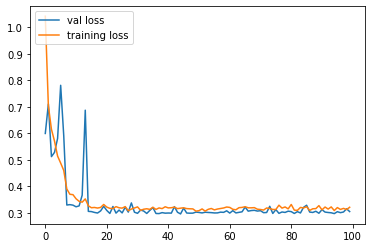

In [38]:
plt.plot(epochs,val_loss, label='val loss')
plt.plot(epochs,_loss, label='training loss')
plt.legend(loc='upper left')

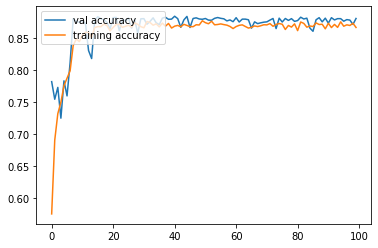

In [39]:
plt.plot(val_epochs,val_accuracy, label='val accuracy')
plt.plot(epochs,accuracy, label='training accuracy')
plt.legend(loc='upper left')

In [40]:
PATH = './perco_density_'+dataname+'_resnet18_no_training_'+str(num_epochs)+'_epochs_Adam_0001_no_shuffle_2000_samples_batch_'+str(batch_size)+'.pth'
torch.save(model.state_dict(), PATH)

## testing the quality of the learned model

In [41]:
def plot4(model): #gives shows only the misclassified images
    from sklearn.preprocessing import LabelEncoder
    from collections import Counter
    global X, Y1
    was_training = model.training
    model.eval()
    #images_so_far = 0
    #fig = plt.figure()
    not_spanning = list(0. for i in range(number_classes))
    spanning = list(0. for i in range(number_classes))
    class_total = list(0. for i in range(number_classes))
    accuracy=list(0. for i in range(number_classes))
    class_names_modified=list(0. for i in range(number_classes))
    pc_0=list(0. for i in range(number_classes))
    pc_1=list(0. for i in range(number_classes))
    sd_0=list(0. for i in range(number_classes))
    sd_1=list(0. for i in range(number_classes))
    with torch.no_grad():
        for i, (inputs,labels,paths) in enumerate(val):
            inputs=inputs.unsqueeze(1)
#             inputs=np.repeat(inputs,3,1)
            inputs=inputs.float()
            inputs=inputs.to(device)
            labels=labels.to(device)
            
            
            outputs = model(inputs) #value of the output neurons
            _, preds = torch.max(outputs, 1) #gives the max value and stores in preds the neurons to which it belongs

            
            for i in range(inputs.size()[0]):
                path=paths[i]
                label = preds[i]
                pc_value=int(path.split('_')[1])
                class_total[label] += 1
                
                if pc_value==1:
                    
                    spanning[label] += pc_value
                    
                if pc_value==0:
                    not_spanning[label] += 1
                    
                    
    for i in range(number_classes):
        pc_1[i]=(spanning[i] / class_total[i])*100
        pc_0[i]=(not_spanning[i] / class_total[i])*100
        class_names_modified[i]=float(class_names[i].replace("p",""))
    
    for i in range(number_classes):
        sd_1[i]=(spanning[i]-(pc_1[i]))**2/(class_total[i])
        sd_0[i]=(not_spanning[i]-(pc_0[i]))**2/(class_total[i])
        
        
        
    plt.figure(figsize=(14,14))
    
    
    plt.plot(class_names_modified,pc_1, label='spanning cluster')
    plt.plot(class_names_modified,pc_0, label='no spanning cluster')
#     print(sd_0)
#     print(sd_1)
 
    plt.legend(loc='best')
            



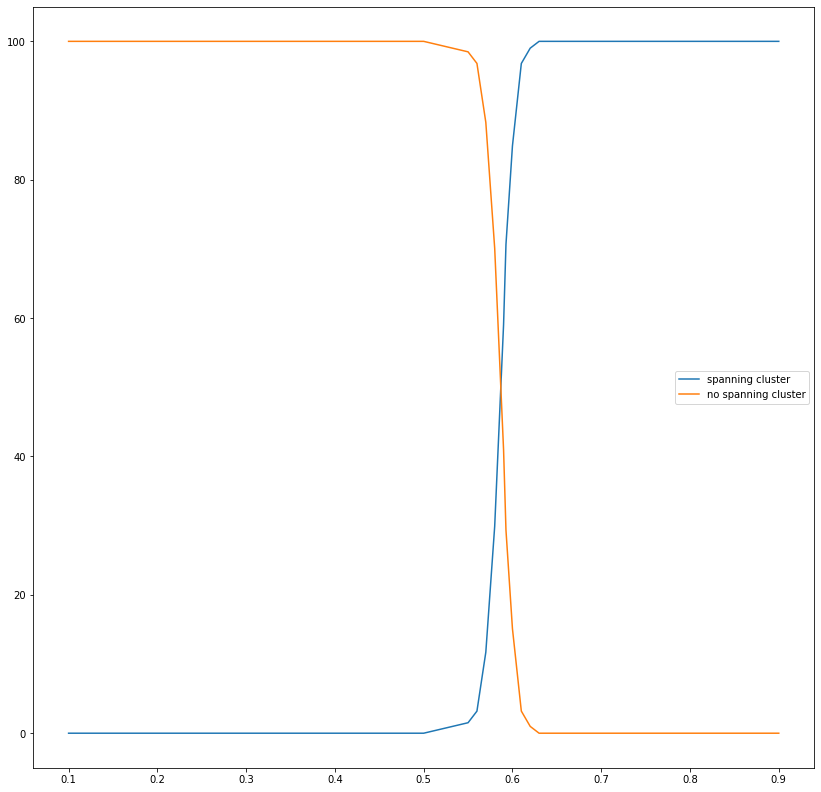

In [42]:
plot4(model)

In [45]:
def plot_quarter(model): #gives shows only the misclassified images
    from sklearn.preprocessing import LabelEncoder
    from collections import Counter
    global X, Y1
    was_training = model.training
    model.eval()
    #images_so_far = 0
    #fig = plt.figure()
    not_spanning = list(0. for i in range(number_classes))
    spanning = list(0. for i in range(number_classes))
    class_total = list(0. for i in range(number_classes))
    accuracy=list(0. for i in range(number_classes))
    class_names_modified=list(0. for i in range(number_classes))
    pc_0=list(0. for i in range(number_classes))
    pc_1=list(0. for i in range(number_classes))
    sd_0=list(0. for i in range(number_classes))
    sd_1=list(0. for i in range(number_classes))
    with torch.no_grad():
        for i, (inputs,labels,paths) in enumerate(val):
            inputs=inputs.unsqueeze(1)
#             inputs=np.repeat(inputs,3,1)
            inputs=inputs.float()
            inputs=inputs.to(device)
            labels=labels.to(device)
            
            
            outputs = model(inputs) #value of the output neurons
            _, preds = torch.max(outputs, 1) #gives the max value and stores in preds the neurons to which it belongs

            
            for i in range(inputs.size()[0]):
                path=paths[i]
                label = preds[i]
                
                class_total[label] += 1
                if int(path.split('_')[1])==1:
#                     print(path)
                    center=int(path.split('_')[11])
                    if center==1:
                        spanning[label] += 1
                    if center==0:
                        not_spanning[label] += 1
                    
                    
    for i in range(number_classes):
        pc_1[i]=(spanning[i] / class_total[i])*100
        pc_0[i]=(not_spanning[i] / class_total[i])*100
        class_names_modified[i]=float(class_names[i].replace("p",""))
    
    for i in range(number_classes):
        sd_1[i]=(spanning[i]-(pc_1[i]))**2/(class_total[i])
        sd_0[i]=(not_spanning[i]-(pc_0[i]))**2/(class_total[i])
        
        
        
    plt.figure(figsize=(14,14))
    
    
    plt.plot(class_names_modified,pc_1, label='spanning cluster')
#     plt.plot(class_names_modified,pc_0, label='no spanning cluster')
#     print(sd_0)
#     print(sd_1)
 
    plt.legend(loc='best')
            

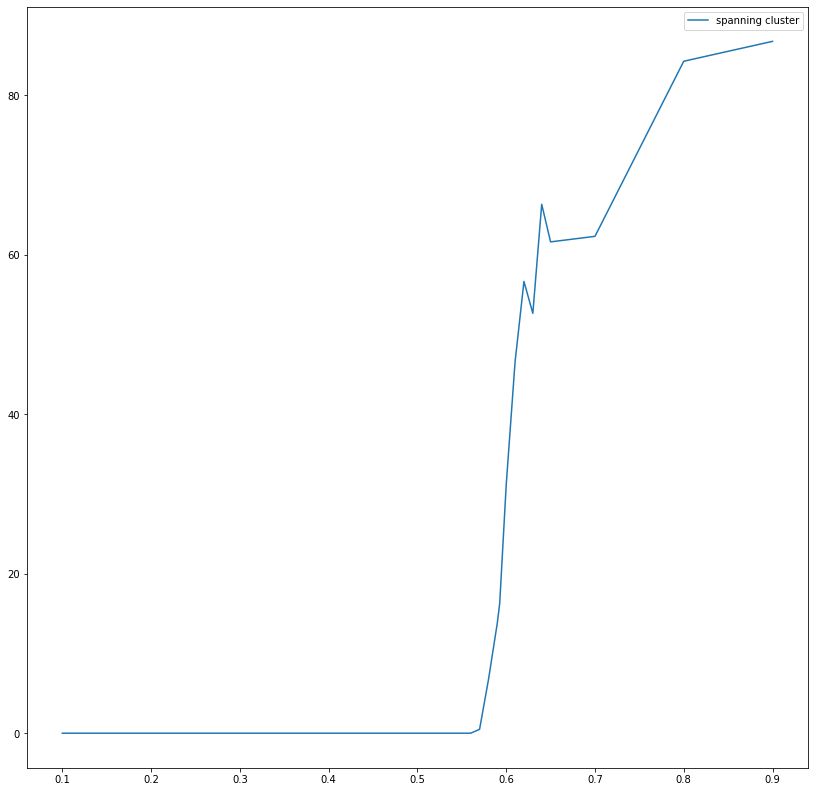

In [46]:
plot_quarter(model)

Accuracy of  p0.1 : 100 %
Accuracy of  p0.2 : 100 %
Accuracy of  p0.3 : 100 %
Accuracy of  p0.4 : 100 %
Accuracy of  p0.5 : 100 %
Accuracy of p0.55 : 87 %
Accuracy of p0.56 : 77 %
Accuracy of p0.57 : 86 %
Accuracy of p0.58 : 89 %
Accuracy of p0.59 : 57 %
Accuracy of p0.5927 : 50 %
Accuracy of  p0.6 : 79 %
Accuracy of p0.61 : 87 %
Accuracy of p0.62 : 85 %
Accuracy of p0.63 : 85 %
Accuracy of p0.64 : 87 %
Accuracy of p0.65 : 95 %
Accuracy of  p0.7 : 100 %
Accuracy of  p0.8 : 100 %
Accuracy of  p0.9 : 100 %
20


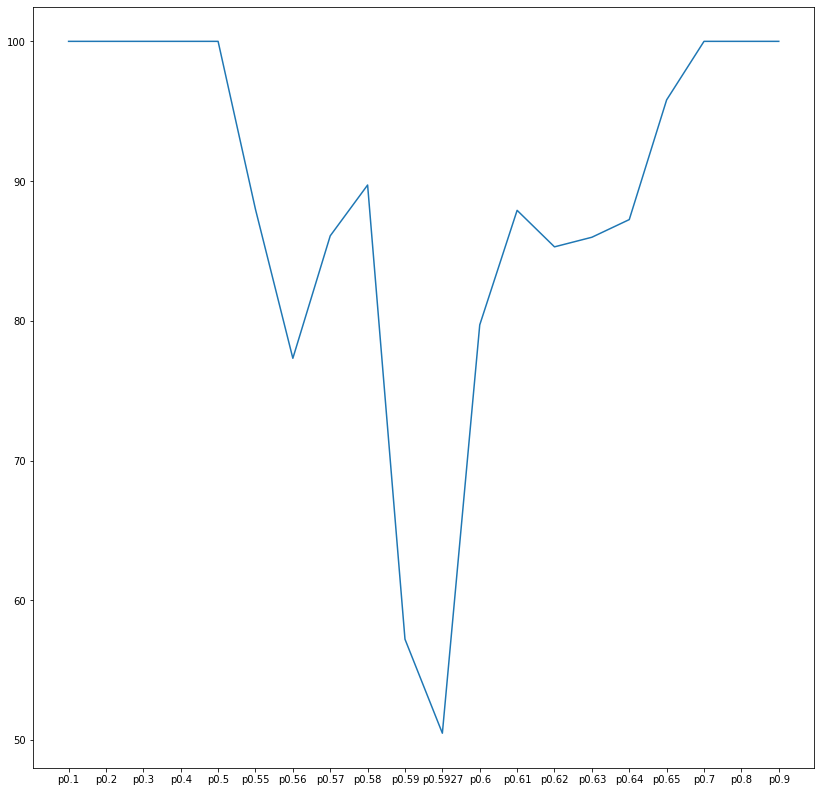

In [53]:
class_correct = list(0. for i in range(number_classes))
class_total = list(0. for i in range(number_classes))
accuracy=list(0. for i in range(number_classes))
average=list(0. for i in range(number_classes))
with torch.no_grad():
     for i, (data) in enumerate(val):
        inputs=data[0]
        labels=data[1]
        inputs=inputs.unsqueeze(1)
#         inputs=np.repeat(inputs,3,1)
        inputs=inputs.float()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1) 

        c = (preds == labels).squeeze()
        for j in range(inputs.size()[0]):
            label = labels[j]
            class_correct[label] += c[j].item()
            class_total[label] += 1


for i in range(number_classes):
    average[i]=(class_correct[i] / class_total[i])*100
#     class_names_modified[i]=float(class_names[i].replace("p",""))
    
    
    
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))

print(len(average))
plt.figure(figsize=(14,14))
plt.plot(class_names,average)


In [54]:
@torch.no_grad()
def simple_confusion_matrix(model,loader):
    confusion_matrix = torch.zeros(number_classes, number_classes)
    for i, (data) in enumerate(loader):
        inputs=data[0]
        labels=data[1]
        inputs=inputs.unsqueeze(1)
#         inputs=np.repeat(inputs,3,1)
        inputs=inputs.float()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1) 
        for t, p in zip(labels.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
                

    return confusion_matrix

In [55]:
cm=simple_confusion_matrix(model,val)
cm

tensor([[201.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0., 196.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0., 199.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0., 187.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0., 201.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0., 183.,  25.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,  15., 150.,  29.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0., 

In [56]:
def confusion_matrix_torch(cm, target_names,cmap=None,title='Confusion Matrix'):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    #accuracy = np.trace(cm) / float(np.sum(cm))
    #misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(25, 25))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=40)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=30)
        plt.yticks(tick_marks, target_names,fontsize=30)

            
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j]),
                    ha="center", va="center",
                    color="white" if  cm[i, j] == 0 or cm[i, j] > thresh else "black") 


    plt.tight_layout()
    plt.ylabel('True label',fontsize=40)
    plt.xlabel('Predicted label',fontsize=40)
    plt.show()

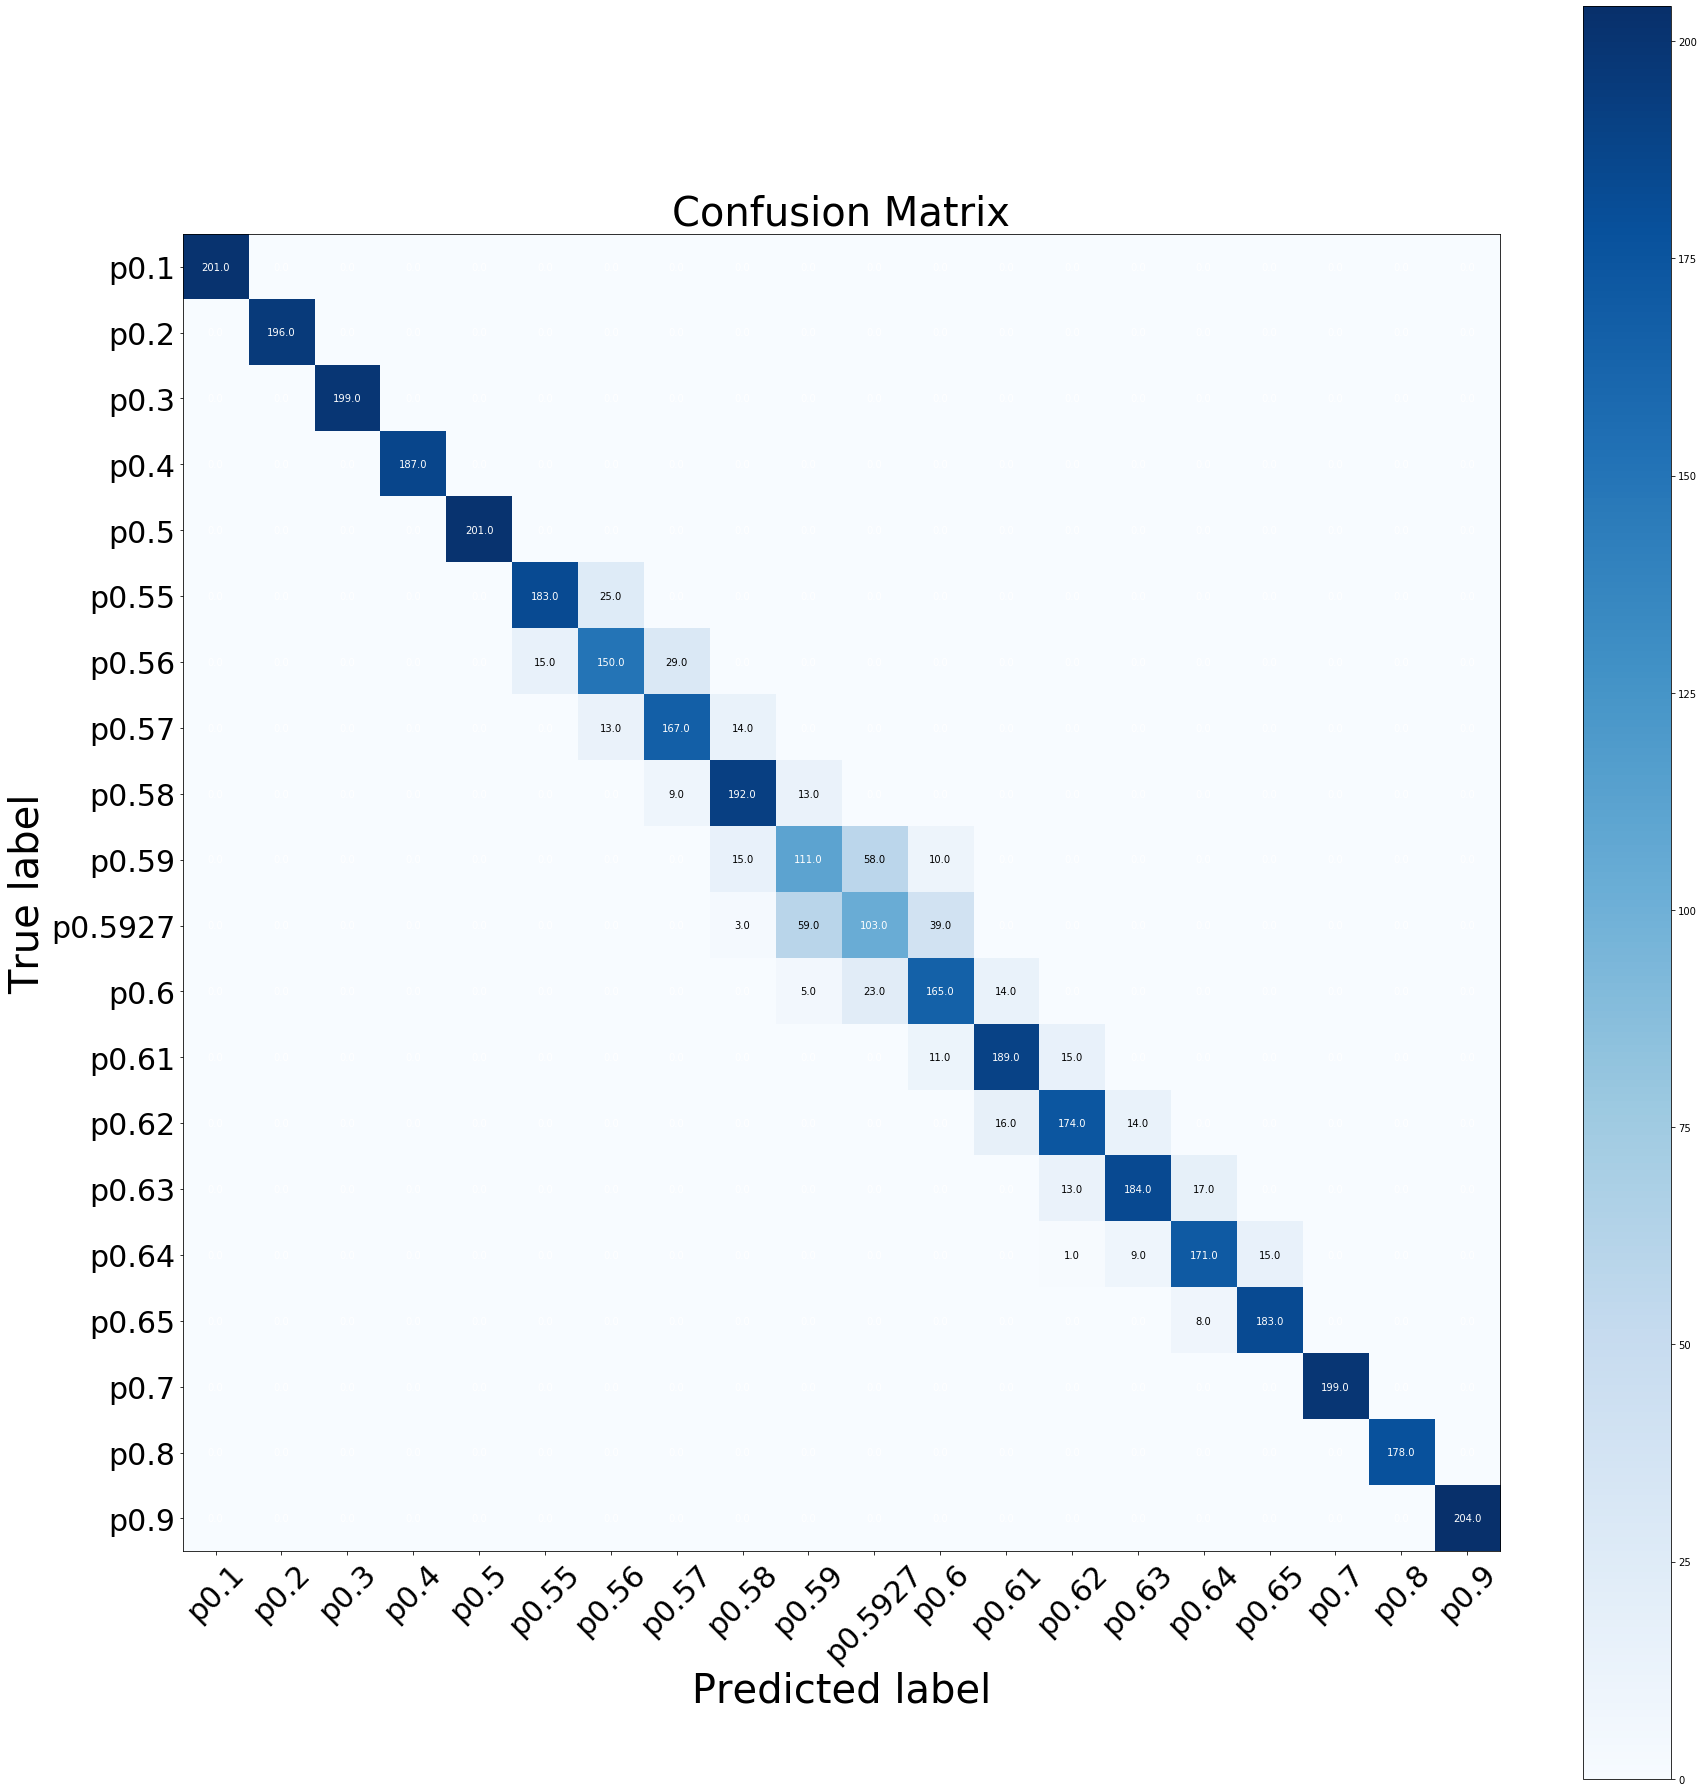

In [57]:
confusion_matrix_torch(cm,class_names)

In [58]:
dataname_test='L100_cross_density'
path_test='../../../../../../media/phrhmb/Datasets_DisQS/Percolation-data/'+dataname_test
#transform=torchvision.transforms.ToTensor()

In [59]:
test_dataset= DatasetFolder2(root=path_test, loader=pickle_loader, extensions='.pkl')
test = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=True)


In [60]:
cm_test=simple_confusion_matrix(model,test)
cm_test

tensor([[100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0., 100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0., 100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0., 100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,  10.,  81.,   9.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,  15.,  77.,   8.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0., 

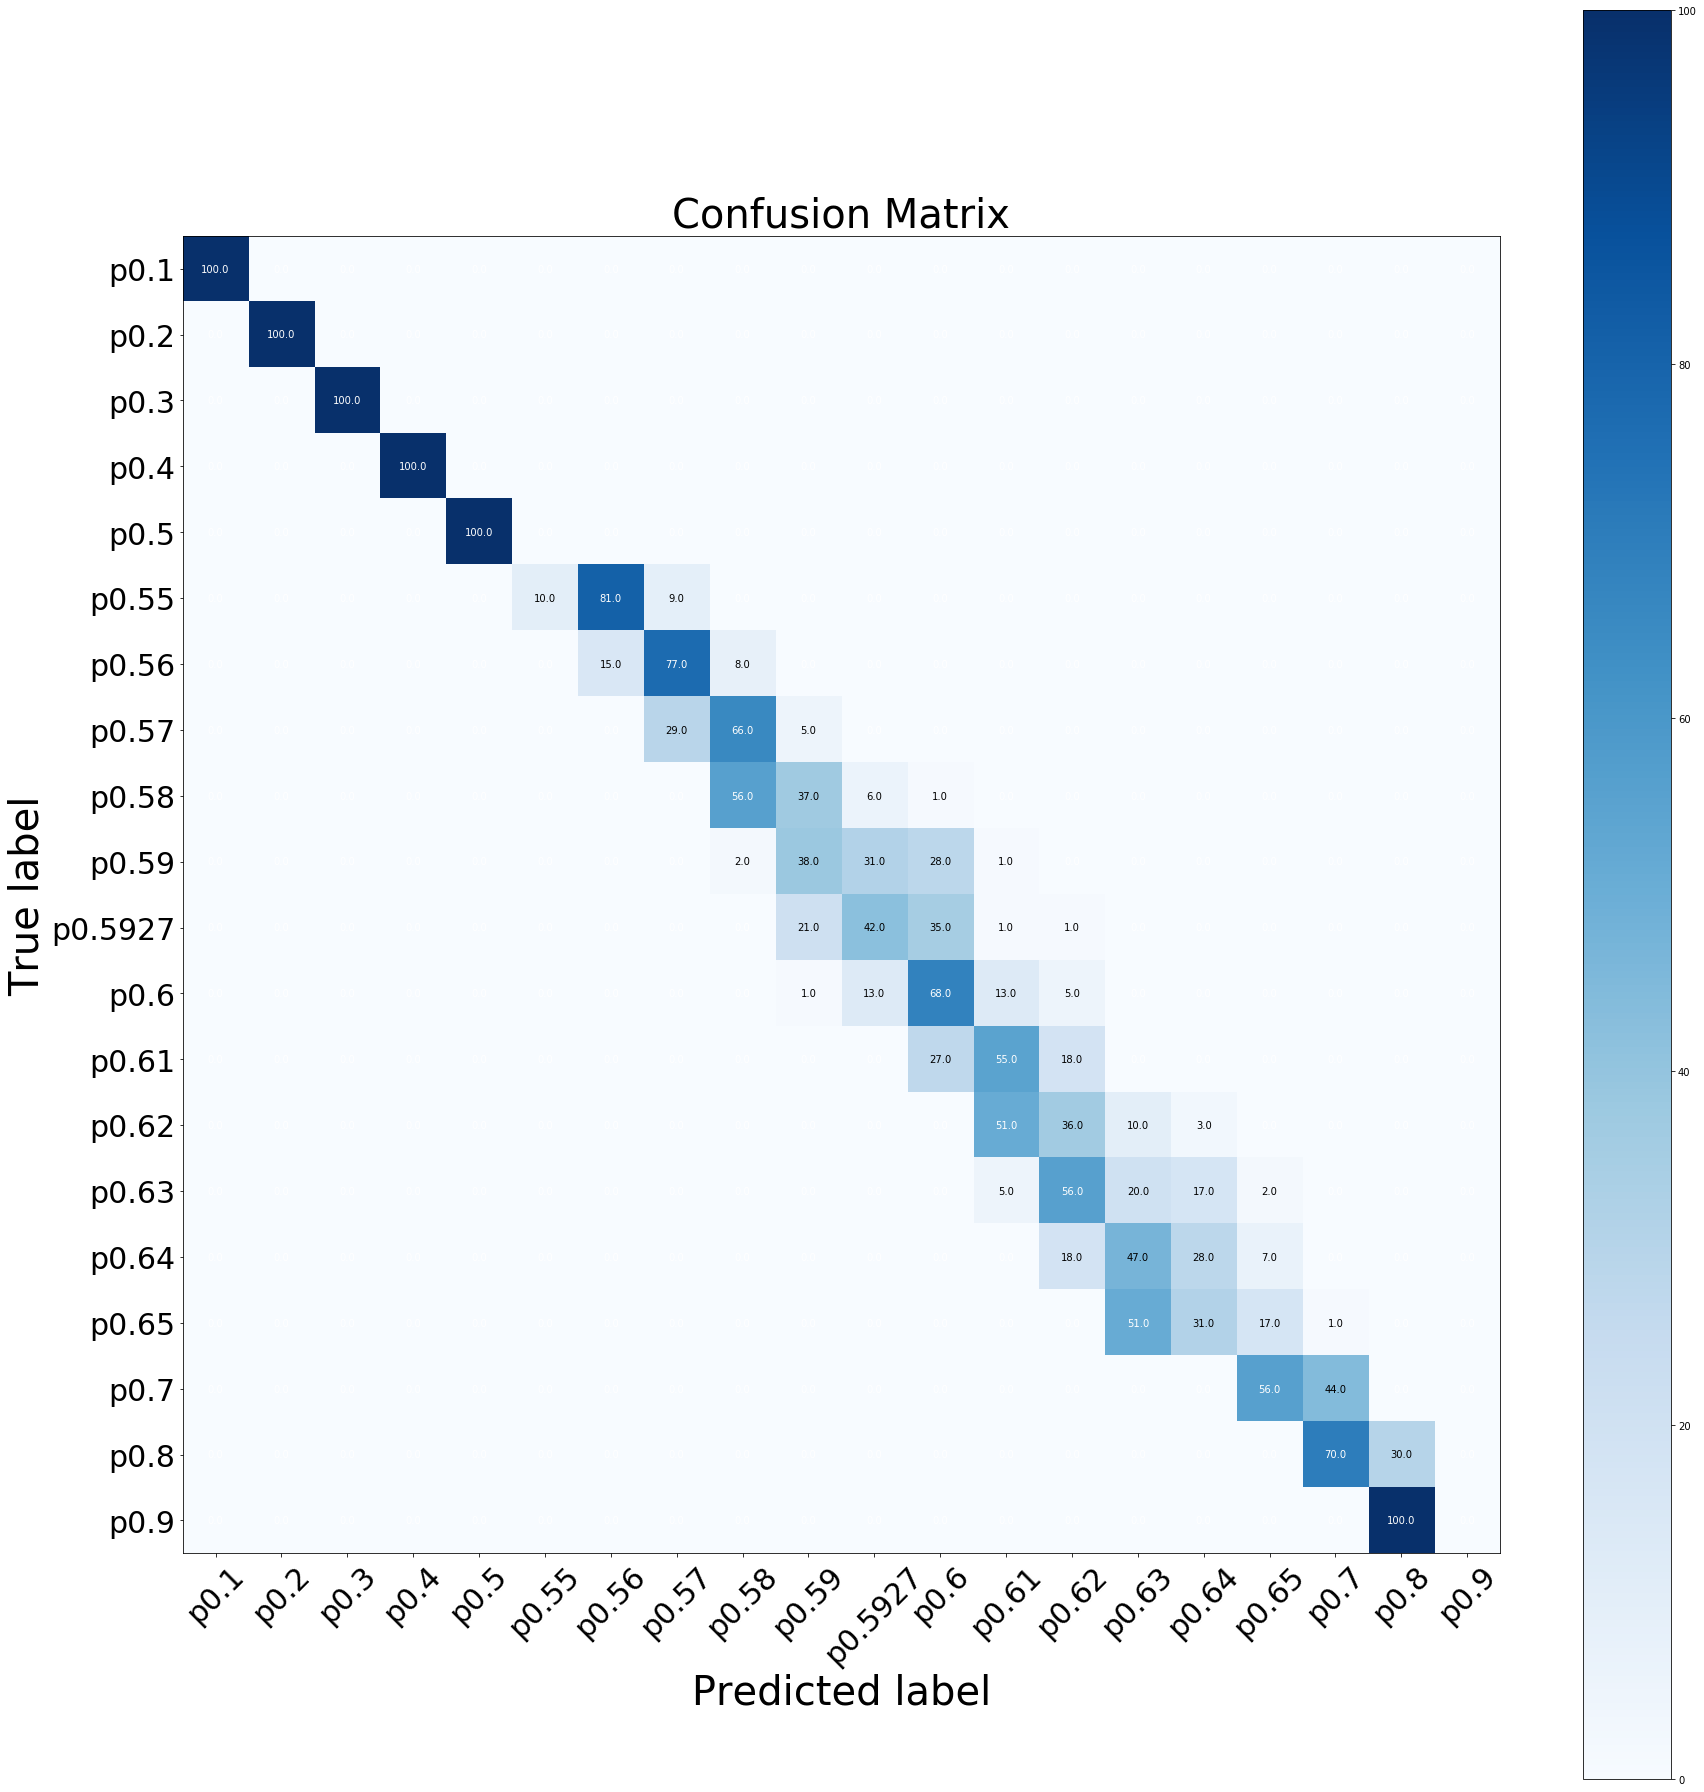

In [62]:
confusion_matrix_torch(cm_test,class_names)